
# Hubbard Spectrum \(A(\mathbf{k},\omega)\) vs \(U\) — **v4 (self‑contained, debugged)**

This notebook is **self‑contained**: it generates synthetic inputs when no DQMC data exist, 
computes spectra along \(\Gamma\!\to\!X\!\to\!M\!\to\!\Gamma\), and checks sum rules.
- If **DQMC files** are found, it performs **Padé analytic continuation** (\(+i\eta\) stabilized).
- If not, it uses a **non‑interacting analytic spectrum** (Lorentzian broadening) → clean baseline and correct normalization.

> Tip: Replace the synthetic files with your measured \(G_{ij}(\tau)\) or \(G(\mathbf{k},\tau)\) to see interacting features.


In [1]:
import os, glob, numpy as np
import numpy.linalg as nla
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, Optional
import time, math
from numpy.linalg import slogdet
from scipy.linalg import expm, qr

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 120


Config Initialize

In [2]:
@dataclass
class Config:
    Nx: int = 6
    Ny: int = 6
    beta: float = 6.0
    t: float = 1.0
    tp: float = 0.0
    mu: Optional[float] = None        # if None at half-filling with NN only, we set mu = U/2 when interacting, and 0 for non-int
    U_list: Tuple[float,...] = (2.0, 4.0, 6.0)
    n_iwn: int = 160                  # used only for Padé branch
    wmax: float = 8.0
    nw: int = 2001
    eta_eval: float = 0.03            # +iη for Padé eval; also Lorentzian HWHM for analytic spectrum
    tau_n: int = 512                  # synthetic τ-grid length (fine for accurate τ→iω integral if needed)
    data_dir: str = "/mnt/data"
    require_data: bool = False        # if True: error when files missing (no synthetic fallback)

cfg = Config()
cfg


Config(Nx=6, Ny=6, beta=6.0, t=1.0, tp=0.0, mu=None, U_list=(2.0, 4.0, 6.0), n_iwn=160, wmax=8.0, nw=2001, eta_eval=0.03, tau_n=512, data_dir='/mnt/data', require_data=False)

Generate synthetic Green function for older pade  

## Synthetic input generator (non‑interacting, **physically correct**)

Creates `G_tau_k__*.npz` and `G_tau_ij__*.npz` for each \(U\) in `cfg.U_list` with:  
$$
G(\mathbf{k},\tau) = -\big(1 - f(\xi_{\mathbf{k}})\big)\,e^{-\xi_{\mathbf{k}}\tau},\quad 0\le\tau<\beta,\ \ \xi_{\mathbf{k}}=\varepsilon_{\mathbf{k}}-\mu.
$$  
This obeys anti-periodicity and produces proper spectra/sum rules. We also save a space–time version by inverse FFT.


In [3]:

def square_eps_k(kx, ky, t: float = 1.0, tp: float = 0.0):
    """Square-lattice dispersion with NN t and NNN t' (tp). Lattice constant a=1."""
    return -2*t*(np.cos(kx)+np.cos(ky)) - 4*tp*np.cos(kx)*np.cos(ky)

def k_path(nx=48):
    G = np.array([0.0, 0.0]); X = np.array([np.pi, 0.0]); M = np.array([np.pi, np.pi])
    pts = [G, X, M, G]
    segs = [np.linspace(a,b,nx,endpoint=False) for a,b in zip(pts[:-1], pts[1:])]
    ks = np.vstack(segs + [pts[-1][None,:]])
    # ticks at the three segment junctions (Γ, X, M, Γ)
    nx_seg = nx
    tick_pos = [0, nx_seg-1, 2*nx_seg-1, 3*nx_seg-1]
    labels = ['Γ','X','M','Γ']
    return ks, tick_pos, labels

In [4]:
def generate_nonint_npz(U_list, Nx, Ny, beta, t, tp, data_dir, tau_n=512):
    os.makedirs(data_dir, exist_ok=True)
    # k-grid and site positions
    kxs = 2*np.pi*np.arange(Nx)/Nx
    kys = 2*np.pi*np.arange(Ny)/Ny
    kgrid = np.array([(kx, ky) for ky in kys for kx in kxs], dtype=float)   # (Nk,2)
    Nk = len(kgrid)
    R = np.array([[ix, iy] for iy in range(Ny) for ix in range(Nx)], dtype=float)  # (N,2)
    Nsites = Nx*Ny

    # τ-grid
    tau = np.linspace(0.0, beta, tau_n, endpoint=False)

    for U in U_list:
        # non-interacting physics for testing; U only labels filenames
        mu = 0.0  # half-filling for NN-only; if tp≠0 you may tune this
        eps_k = np.array([square_eps_k(kx, ky, t=t, tp=tp) for (kx,ky) in kgrid])  # (Nk,)
        xi_k = eps_k - mu
        f = 1.0/(np.exp(beta*xi_k) + 1.0)  # Fermi-Dirac

        # Exact finite-T G(k,τ) for 0<=τ<β
        G_tau_k = np.empty((tau_n, Nk), dtype=complex)
        for it, tau_val in enumerate(tau):
            G_tau_k[it, :] = -(1.0 - f) * np.exp(-xi_k * tau_val)

        # Also build G_ij(τ) by inverse Fourier (for compatibility)
        G_tau_ij = np.zeros((tau_n, Nsites, Nsites), dtype=complex)
        for ik, (kx,ky) in enumerate(kgrid):
            phase = np.exp(1j*(R[:,0]*kx + R[:,1]*ky))  # e^{i k·R}
            P = np.outer(phase.conj(), phase) / Nsites   # (i,j) -> e^{-ik·(R_i-R_j)}/N
            for it in range(tau_n):
                G_tau_ij[it] += P * G_tau_k[it, ik]

        tag = f"U{U:.2f}_Nx{Nx}_Ny{Ny}_beta{beta:.2f}"
        np.savez_compressed(os.path.join(data_dir, f"G_tau_k__{tag}.npz"),
                            G_tau_k=G_tau_k, tau=tau, kgrid=kgrid)
        np.savez_compressed(os.path.join(data_dir, f"G_tau_ij__{tag}.npz"),
                            G_tau_ij=G_tau_ij, tau=tau)
        print("[synthetic] wrote:", f"G_tau_k__{tag}.npz", "and", f"G_tau_ij__{tag}.npz")

# Generate synthetic files unless user sets require_data=True and has real files
if not cfg.require_data:
    generate_nonint_npz(cfg.U_list, cfg.Nx, cfg.Ny, cfg.beta, cfg.t, cfg.tp, cfg.data_dir, tau_n=cfg.tau_n)


[synthetic] wrote: G_tau_k__U2.00_Nx6_Ny6_beta6.00.npz and G_tau_ij__U2.00_Nx6_Ny6_beta6.00.npz
[synthetic] wrote: G_tau_k__U4.00_Nx6_Ny6_beta6.00.npz and G_tau_ij__U4.00_Nx6_Ny6_beta6.00.npz
[synthetic] wrote: G_tau_k__U6.00_Nx6_Ny6_beta6.00.npz and G_tau_ij__U6.00_Nx6_Ny6_beta6.00.npz


### Spectrum computation main function  

In [5]:
# --- Hubbard-I real-axis spectrum (no analytic continuation) ---
def hubbardI_Akw(U, kgrid, wgrid, t=1.0, tp=0.0, mu=None, filling=1.0, eta=0.05):
    """
    Hubbard-I self-energy (paramagnetic). Works best near half-filling and larger U.
    Total filling per site = `filling` (1.0 at half-filling); per-spin nσ = filling/2.

    Σ_HI(ω) = U^2 nσ(1-nσ) / [ ω + μ - U(1-nσ) ]
    At half-filling (filling=1, μ=U/2): Σ_HI(ω) = (U^2/4) / (ω + iη)  (PH-symmetric).
    """
    if mu is None:
        # particle-hole symmetric choice at half-filling
        mu = U/2.0 if abs(filling-1.0) < 1e-8 else 0.0

    n_sigma = 0.5 * filling  # per spin
    def Sigma(z):
        return (U**2 * n_sigma * (1.0 - n_sigma)) / (z + mu - U*(1.0 - n_sigma))

    # lattice dispersion
    eps = np.array([-2*t*(np.cos(kx)+np.cos(ky)) - 4*tp*np.cos(kx)*np.cos(ky)
                    for (kx,ky) in kgrid], dtype=float)

    z = wgrid[None, :] + 1j*eta
    Akw = np.zeros((len(eps), len(wgrid)), dtype=float)
    for ik, ek in enumerate(eps):
        Gret = 1.0 / (z + mu - ek - Sigma(z))
        Akw[ik, :] = -np.imag(Gret)/np.pi
    return Akw


POST helper functions  

In [6]:
## Plot Spectrum

def plot_Akw_kpath(kgrid_all: np.ndarray, Akw_all: np.ndarray, wgrid: np.ndarray, title: str = "A(k, ω)"):
    ks, tick_pos, labels = k_path(nx=48)
    # nearest indices
    diffs = kgrid_all[None,:,:] - ks[:,None,:]
    idxs = np.argmin(np.sum(diffs**2, axis=2), axis=1)
    Aline = Akw_all[idxs]  # (npath, nw)

    plt.figure()
    plt.imshow(Aline.T, origin="lower", aspect="auto",
               extent=[0, len(ks)-1, wgrid[0], wgrid[-1]])
    plt.colorbar(label="A(k, ω)")
    plt.xticks(tick_pos, labels)
    plt.xlabel("k-path Γ–X–M–Γ"); plt.ylabel("ω/t"); plt.title(title); plt.show()

## Estimate gap

def estimate_gap_from_dos(w, dos, frac_of_max=0.03):
    """Return symmetric charge gap size 2*Δ/2 as the distance between
    first DOS>threshold crossings on ± sides of ω=0."""
    thr = frac_of_max * np.max(dos)
    # left side: walk from 0- towards negative, find crossing
    left_mask  = (w < 0)
    right_mask = (w > 0)
    wl, dl = w[left_mask],  dos[left_mask]
    wr, dr = w[right_mask], dos[right_mask]

    # left crossing (from below thr to above thr as |ω| increases)
    li = np.where((dl[:-1] < thr) & (dl[1:] >= thr))[0]
    # right crossing
    ri = np.where((dr[:-1] < thr) & (dr[1:] >= thr))[0]

    if li.size == 0 or ri.size == 0:
        return 0.0  # no clear gap at this threshold

    # linear interpolation to the crossing points
    iL = li[0]
    wL = wl[iL] + (wl[iL+1]-wl[iL]) * (thr - dl[iL]) / (dl[iL+1]-dl[iL])

    iR = ri[0]
    wR = wr[iR] + (wr[iR+1]-wr[iR]) * (thr - dr[iR]) / (dr[iR+1]-dr[iR])

    return max(0.0, wR - wL)

## Estimate Z weight 

def sigma_hubbardi_z(z, U, filling=1.0, mu=None):
    """
    Hubbard-I self-energy Σ(z) for arbitrary complex z.
    At half filling (filling=1.0) we set μ=U/2 if not provided.
    """
    if mu is None:
        mu = U/2.0 if abs(filling-1.0) < 1e-12 else 0.0
    n_sigma = 0.5 * filling
    return (U**2 * n_sigma * (1.0 - n_sigma)) / (z + mu - U*(1.0 - n_sigma))

def Z_from_sigma_matsubara(beta, U, filling=1.0, mu=None, n0=0):
    """
    Finite-T quasiparticle weight estimator:
      Z ≈ [1 - Im Σ(iω_n0)/ω_n0]^{-1}, ω_n=(2n+1)π/β (use n0=0 by default).
    For Hubbard-I at half filling, this reduces to Z = 1 / (1 + (Uβ/2π)^2).
    Works for general filling too (via sigma_hubbardi_z).
    """
    iwn = 1j * (2*n0 + 1) * np.pi / beta
    Sigma_iwn = sigma_hubbardi_z(iwn, U, filling=filling, mu=mu)
    ratio = np.imag(Sigma_iwn) / np.imag(iwn)
    return 1.0 / (1.0 - ratio)

Evaluate gap helper functions  

In [7]:
def estimate_gap_from_dos_robust(w, dos, frac_of_max=0.04, sigma=2):
    """
    Return the symmetric charge gap around ω=0 as the width of the connected
    region around 0 where DOS < threshold. If DOS(0) >= thr, gap = 0.
    - frac_of_max: threshold = frac * max(DOS)
    - sigma: integer smoothing window (Savitzky–Golay-style boxcar)
    """
    # mild smoothing to kill single-bin spikes (boxcar)
    if sigma > 1:
        k = int(sigma)
        ker = np.ones(2*k+1)/(2*k+1)
        dos_s = np.convolve(dos, ker, mode="same")
    else:
        dos_s = dos

    thr = max(frac_of_max * np.max(dos_s), 1e-3)  # floor prevents 'zero' threshold

    # find index closest to ω=0
    i0 = int(np.argmin(np.abs(w)))
    if dos_s[i0] >= thr:
        return 0.0  # metallic at this threshold

    # expand left/right from 0 until DOS crosses the threshold
    iL = i0
    while iL > 0 and dos_s[iL] < thr:
        iL -= 1
    iR = i0
    while iR < len(w)-1 and dos_s[iR] < thr:
        iR += 1

    # linear interpolation for sub-bin accuracy
    def xcross(i, dir):
        # dir=-1 uses (i, i+1) on left side; dir=+1 uses (i, i-1) on right side
        if dir < 0:
            a, b = i, i+1
        else:
            a, b = i, i-1
        if b < 0 or b >= len(w): 
            return w[a]
        da, db = dos_s[a], dos_s[b]
        if da == db: 
            return w[a]
        t = (thr - da) / (db - da)
        return w[a] + t*(w[b]-w[a])

    wL = xcross(iL, dir=-1)
    wR = xcross(iR, dir=+1)
    return max(0.0, wR - wL)

def predicted_gap_HI(U, t=1.0):
    W = 8.0*t
    return max(0.0, U - W)

def delta_HI_exact(U, t=1.0):  # Hubbard-I gap on square lattice
    return np.sqrt(U**2 + (4*t)**2) - 4*t


[Hubbard-I] U/t = 2.0
  Z_HI(β=6.00) ≈ 0.2152
  M0 mean±std: 0.993 ± 0.001
U=2.0  predicted Δ=0.000   measured Δ≈0.304
U= 2.0  Δ_HI=0.472   measured≈0.304   N(0)≈2.456e-02


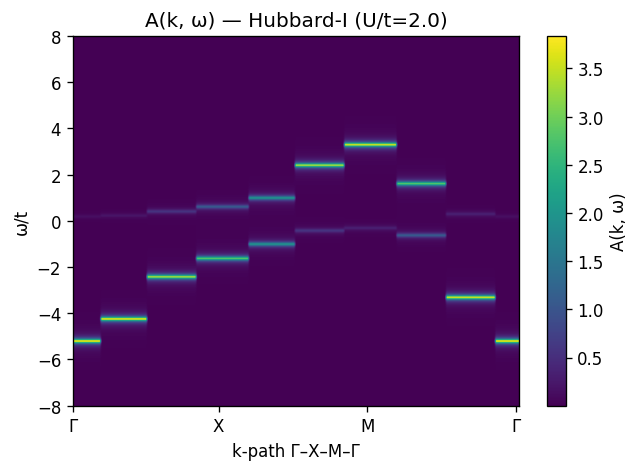

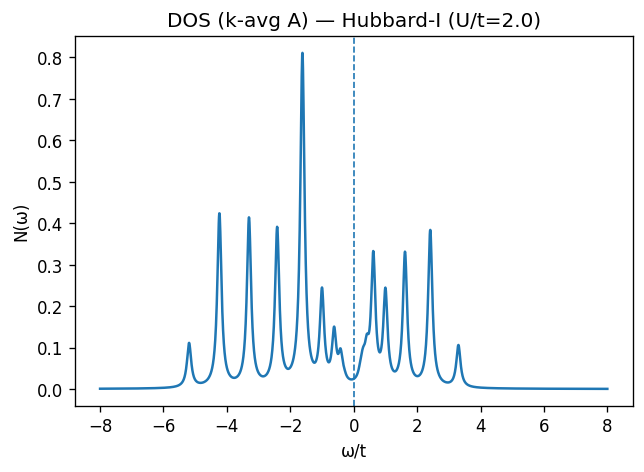

[Hubbard-I] U/t = 4.0
  Z_HI(β=6.00) ≈ 0.0641
  M0 mean±std: 0.992 ± 0.002
U=4.0  predicted Δ=0.000   measured Δ≈1.721
U= 4.0  Δ_HI=1.657   measured≈1.721   N(0)≈6.336e-03


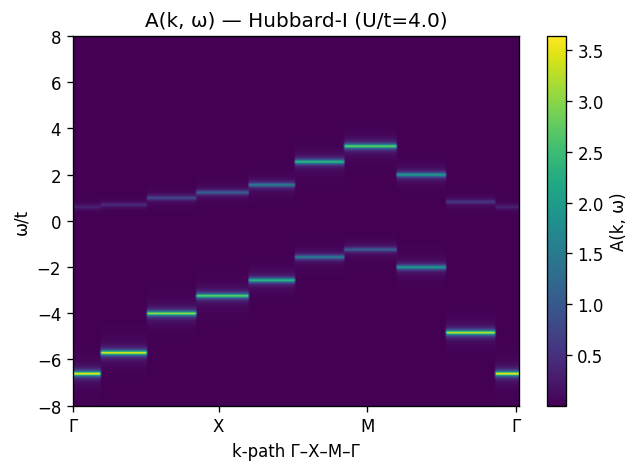

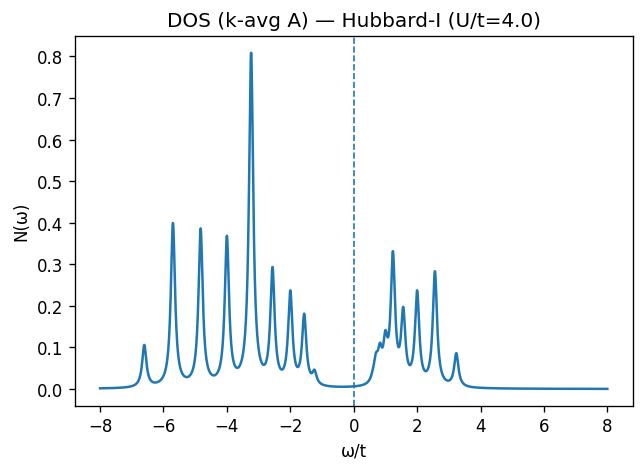

[Hubbard-I] U/t = 6.0
  Z_HI(β=6.00) ≈ 0.0296
  M0 mean±std: 0.969 ± 0.114
U=6.0  predicted Δ=0.000   measured Δ≈3.522
U= 6.0  Δ_HI=3.211   measured≈3.522   N(0)≈2.825e-03


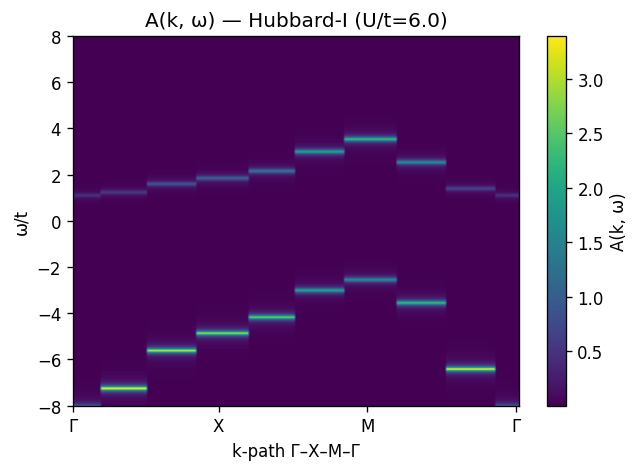

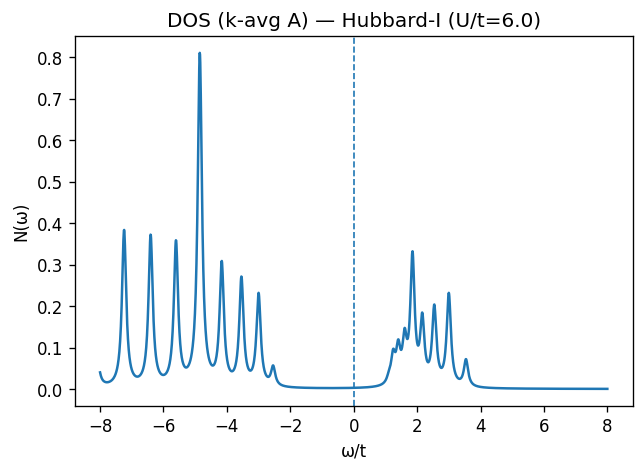

In [8]:
# --- Compute and plot A(k, ω) with Hubbard-I; also show DOS to see the gap ---
wgrid = np.linspace(-cfg.wmax, cfg.wmax, cfg.nw)

# uniform k-grid matching Nx, Ny
kxs = 2*np.pi*np.arange(cfg.Nx)/cfg.Nx
kys = 2*np.pi*np.arange(cfg.Ny)/cfg.Ny
kgrid_uniform = np.array([(kx, ky) for ky in kys for kx in kxs], dtype=float)

for U in cfg.U_list:
    print(f"[Hubbard-I] U/t = {U}")
    Akw = hubbardI_Akw(U, kgrid_uniform, wgrid, t=cfg.t, tp=cfg.tp,
                        mu=None, filling=1.0, eta=0.08)  # η a bit larger → smoother DOS
    # --- NEW: Z (Matsubara estimator, robust & Padé-free) ---
    Z_hi = Z_from_sigma_matsubara(cfg.beta, U, filling=1.0, mu=None, n0=0)
    print(f"  Z_HI(β={cfg.beta:.2f}) ≈ {Z_hi:.4f}")
    
    dw  = float(np.mean(np.diff(wgrid)))
    M0  = np.trapz(Akw, dx=dw, axis=1)
    print(f"  M0 mean±std: {M0.mean():.3f} ± {M0.std():.3f}")
    DOS = Akw.mean(axis=0)
    gap_meas = estimate_gap_from_dos_robust(wgrid, DOS, frac_of_max=0.04, sigma=2)
    print(f"U={U:.1f}  predicted Δ={predicted_gap_HI(U,cfg.t):.3f}   measured Δ≈{gap_meas:.3f}")
    print(f"U={U:>4.1f}  Δ_HI={delta_HI_exact(U,cfg.t):.3f}   measured≈{gap_meas:.3f}   N(0)≈{DOS[np.argmin(np.abs(wgrid))]:.3e}")
    plot_Akw_kpath(kgrid_uniform, Akw, wgrid, title=f"A(k, ω) — Hubbard‑I (U/t={U:.1f})")
    plt.figure(); plt.plot(wgrid, DOS); plt.axvline(0, ls="--", lw=1)
    plt.title(f"DOS (k-avg A) — Hubbard‑I (U/t={U:.1f})")
    plt.xlabel("ω/t"); plt.ylabel("N(ω)"); plt.show()


RPA

In [9]:
# RPA χ(q) selector – self-contained, no external data
import numpy as np, math, time
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Optional

plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['figure.dpi'] = 120

# ---------- Config ----------
@dataclass
class RPAConfig:
    Nx: int = 256          # momentum grid (use 256 for publication-quality; 128 for speed)
    Ny: int = 256
    beta: float = 20.0     # low T to sharpen the selector
    t: float = 1.0
    tp: float = 0.0        # next-nearest neighbor
    mu: Optional[float] = 0.0  # half-filling if tp=0 -> μ=0; if tp≠0 you may tune μ to keep n=1
    U: float = 1.0         # weak-coupling side
    qdraw_clip: float = 0.995 # clip χ_RPA color scale to avoid blow-up near the pole
    path_n: int = 200      # k-path resolution for line-cuts

cfg_rpa = RPAConfig()
cfg_rpa


RPAConfig(Nx=256, Ny=256, beta=20.0, t=1.0, tp=0.0, mu=0.0, U=1.0, qdraw_clip=0.995, path_n=200)

In [10]:
def square_eps_k(kx, ky, t=1.0, tp=0.0):
    # ε(k) = -2t(cos kx + cos ky) - 4tp cos kx cos ky
    return -2*t*(np.cos(kx)+np.cos(ky)) - 4*tp*np.cos(kx)*np.cos(ky)

def k_mesh(Nx, Ny):
    kx = 2*np.pi*np.arange(Nx)/Nx
    ky = 2*np.pi*np.arange(Ny)/Ny
    KX, KY = np.meshgrid(kx, ky, indexing='ij')  # (Nx,Ny)
    return KX, KY

def fermi(eps, beta):
    # f(ε) = 1/(e^{β ε}+1)
    x = beta*eps
    # numerical safety
    x = np.clip(x, -700, 700)
    return 1.0/(np.exp(x)+1.0)

def dfermi_de(eps, beta):
    # -∂f/∂ε = β e^{β ε}/(e^{β ε}+1)^2 = β f(1-f)
    f = fermi(eps, beta)
    return beta * f * (1.0 - f)

def k_path(path_n=200):
    Γ = np.array([0.0, 0.0]); X = np.array([np.pi, 0.0]); M = np.array([np.pi, np.pi])
    pts  = [Γ, X, M, Γ]
    segs = [np.linspace(a,b,path_n,endpoint=False) for a,b in zip(pts[:-1], pts[1:])]
    ks   = np.vstack(segs + [pts[-1][None,:]])
    ticks = [0, path_n, 2*path_n, 3*path_n]
    labels = ['Γ','X','M','Γ']
    return ks, ticks, labels


In [11]:
def chi0_static(cfg: RPAConfig):
    Nx, Ny, beta, t, tp, mu = cfg.Nx, cfg.Ny, cfg.beta, cfg.t, cfg.tp, cfg.mu
    KX, KY = k_mesh(Nx, Ny)
    eps = square_eps_k(KX, KY, t=t, tp=tp)
    xi  = eps - (0.0 if mu is None else mu)
    f   = fermi(xi, beta)
    df  = dfermi_de(xi, beta)  # = β f(1-f)

    chi0 = np.zeros((Nx, Ny), dtype=np.float64)

    # Loop over q via index shifts; use masked safe divide to avoid warnings
    for iqx in range(Nx):
        kx2_idx = (np.arange(Nx) + iqx) % Nx
        for iqy in range(Ny):
            ky2_idx = (np.arange(Ny) + iqy) % Ny

            xi_q = xi[np.ix_(kx2_idx, ky2_idx)]
            f_q  = f[np.ix_(kx2_idx, ky2_idx)]

            num = f - f_q
            den = xi - xi_q

            # mask "degenerate" points and do safe division elsewhere
            mask = np.abs(den) < 1e-12

            ratio = np.empty_like(den, dtype=np.float64)
            # ratio = num/den only where |den|>=tol
            np.divide(num, den, out=ratio, where=~mask)
            # fill masked entries with the derivative limit
            ratio[mask] = df[mask]

            chi0[iqx, iqy] = - np.mean(ratio)

    return chi0


[timing] χ0+RPA computed on 256×256 in 29.59s
[selector] max χ0 at q≈(3.117,3.142);
           χ0(Q=(π,π)) = 0.793851;  Stoner margin 1−Uχ0(Q) = 2.061495e-01


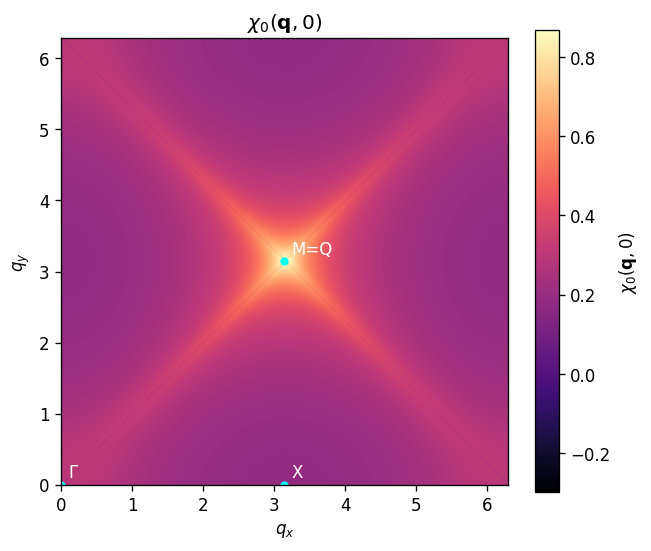

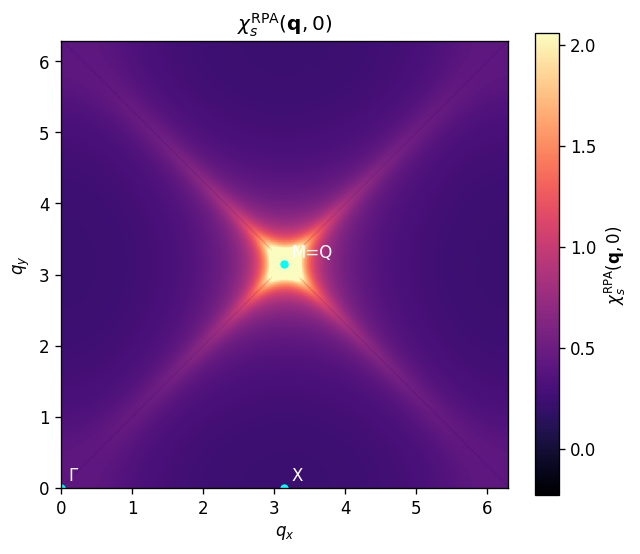

In [12]:
def rpa_from_chi0(chi0, U):
    return chi0 / (1.0 - U*chi0)

def find_nearest_q_index(Nx, Ny, q_target=(np.pi, np.pi)):
    qx = 2*np.pi*np.arange(Nx)/Nx
    qy = 2*np.pi*np.arange(Ny)/Ny
    ix = int(np.argmin(np.abs((qx - q_target[0] + np.pi) % (2*np.pi) - np.pi)))
    iy = int(np.argmin(np.abs((qy - q_target[1] + np.pi) % (2*np.pi) - np.pi)))
    return ix, iy

def plot_heatmap(Z, title, vmax_clip=None):
    Nx, Ny = Z.shape
    extent = [0, 2*np.pi, 0, 2*np.pi]
    plt.figure()
    vmax = None
    if vmax_clip is not None:
        q = float(np.clip(vmax_clip, 0.0, 1.0))
        vmax = np.quantile(Z, q)
    im = plt.imshow(Z.T, origin='lower', extent=extent, aspect='equal', cmap='magma',
                    vmin=None, vmax=vmax)
    plt.colorbar(im, label=title)
    plt.xlabel(r"$q_x$")
    plt.ylabel(r"$q_y$")
    plt.title(title)
    for (qx, qy, lab) in [(0,0,'Γ'), (np.pi,0,'X'), (np.pi,np.pi,'M=Q')]:
        plt.scatter([qx],[qy], s=16, c='cyan'); plt.text(qx+0.1, qy+0.1, lab, color='w')
    plt.show()

t0 = time.time()
chi0 = chi0_static(cfg_rpa)
chi_rpa = rpa_from_chi0(chi0, cfg_rpa.U)
dt = time.time() - t0
print(f"[timing] χ0+RPA computed on {cfg_rpa.Nx}×{cfg_rpa.Ny} in {dt:.2f}s")

# Report selector and Stoner margin
ixQ, iyQ = find_nearest_q_index(cfg_rpa.Nx, cfg_rpa.Ny, (np.pi, np.pi))
chi0_Q = float(chi0[ixQ, iyQ])
stoner_margin = 1.0 - cfg_rpa.U * chi0_Q

imax = np.unravel_index(np.argmax(chi0), chi0.shape)
qmax = (2*np.pi*imax[0]/cfg_rpa.Nx, 2*np.pi*imax[1]/cfg_rpa.Ny)

print(f"[selector] max χ0 at q≈({qmax[0]:.3f},{qmax[1]:.3f});")
print(f"           χ0(Q=(π,π)) = {chi0_Q:.6f};  Stoner margin 1−Uχ0(Q) = {stoner_margin:.6e}")

# Heatmaps (NOTE the braces in \mathbf{q})
plot_heatmap(chi0,   r"$\chi_0(\mathbf{q},0)$")
plot_heatmap(chi_rpa, r"$\chi^{\rm RPA}_s(\mathbf{q},0)$", vmax_clip=cfg_rpa.qdraw_clip)


[selector @ Q=(π,π)]  χ0(Q)=0.793851   χ_s^RPA(Q)=3.850849   U=1.000   U_c≈1.259683   1−Uχ0(Q)=2.061495e-01


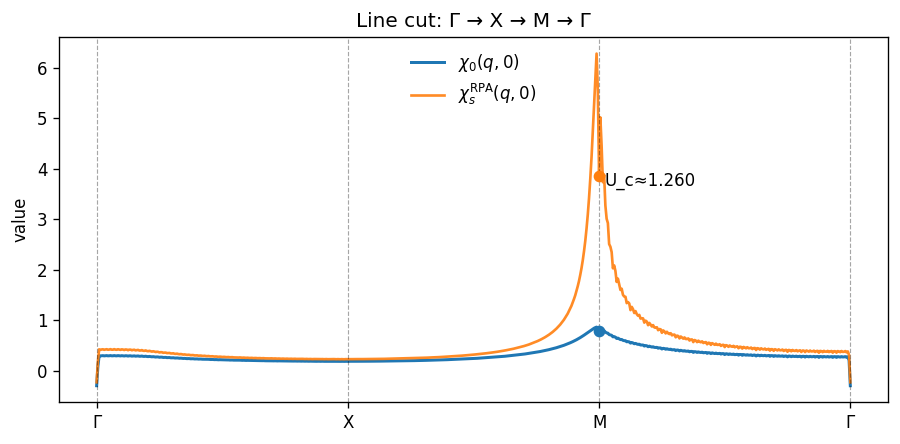

In [13]:
# --- Cell 5 (fixed MathText + smoother sampling + U_c print) ---

from scipy.interpolate import RegularGridInterpolator

def sample_on_path_bilinear(field_2d, Nx, Ny, path_n=200):
    """Bilinear sample field_2d on Γ→X→M→Γ for a smooth line cut."""
    ks, ticks, labels = k_path(path_n)
    # grid in q-space
    qx = 2*np.pi*np.arange(Nx)/Nx
    qy = 2*np.pi*np.arange(Ny)/Ny
    interp = RegularGridInterpolator((qx, qy), field_2d, bounds_error=False, fill_value=None)

    # bring every k back to principal BZ (0..2π) then sample
    pts = np.empty((len(ks), 2))
    pts[:,0] = (ks[:,0] + 2*np.pi) % (2*np.pi)
    pts[:,1] = (ks[:,1] + 2*np.pi) % (2*np.pi)
    vals = interp(pts)
    return vals, ticks, labels

# Line data
line_chi0, ticks, labels = sample_on_path_bilinear(chi0,   cfg_rpa.Nx, cfg_rpa.Ny, cfg_rpa.path_n)
line_rpa,  _,     _      = sample_on_path_bilinear(chi_rpa, cfg_rpa.Nx, cfg_rpa.Ny, cfg_rpa.path_n)

# Annotate the M tick, print χ0(Q), χRPA(Q), Stoner margin, and save figures.
ixQ, iyQ = find_nearest_q_index(cfg_rpa.Nx, cfg_rpa.Ny, (np.pi, np.pi))
chi0_Q   = float(chi0[ixQ, iyQ])
chiRPA_Q = float(chi_rpa[ixQ, iyQ])
Uc       = 1.0 / chi0_Q
stoner   = 1.0 - cfg_rpa.U * chi0_Q

print(f"[selector @ Q=(π,π)]  χ0(Q)={chi0_Q:.6f}   χ_s^RPA(Q)={chiRPA_Q:.6f}   "
      f"U={cfg_rpa.U:.3f}   U_c≈{Uc:.6f}   1−Uχ0(Q)={stoner:.6e}")

# Replot line cut with a marker at M
plt.figure(figsize=(7.6,3.8))
plt.plot(line_chi0, label=r'$\chi_0(q,0)$', lw=1.8)
plt.plot(line_rpa,  label=r'$\chi^{\mathrm{RPA}}_s(q,0)$', lw=1.6, alpha=0.9)
for t in ticks: plt.axvline(t, ls='--', lw=0.7, color='k', alpha=0.35)
plt.xticks(ticks, ['Γ','X','M','Γ'])
plt.ylabel('value'); plt.title('Line cut: Γ → X → M → Γ')
# mark M index
m_idx = ticks[2]
plt.scatter([m_idx],[line_chi0[m_idx]], c='C0', zorder=5)
plt.scatter([m_idx],[line_rpa[m_idx]],  c='C1', zorder=5)
plt.text(m_idx+4, line_rpa[m_idx]*0.95, f"U_c≈{Uc:.3f}", fontsize=10)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("rpa_linecut_GXM_G.png", dpi=300, bbox_inches='tight')
plt.savefig("rpa_linecut_GXM_G.svg", bbox_inches='tight')
plt.show()


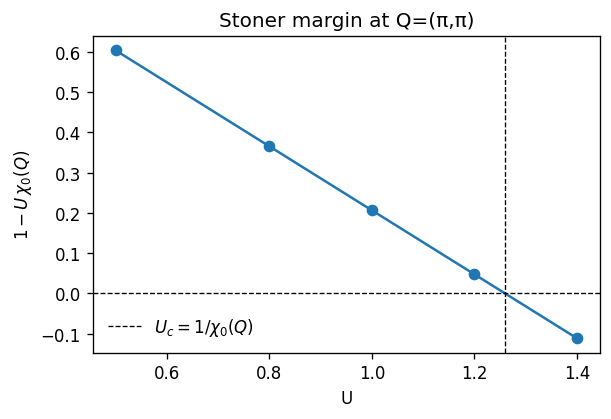

[report] χ0(Q)=0.793851 → U_c≈1.259683


In [14]:
# Sweep a few small U to show 1 - U χ0(Q) trend (no need to recompute χ0)
U_grid = np.array([0.5, 0.8, 1.0, 1.2, 1.4])
chi0Q  = chi0_Q  # from above
stoner_vals = 1.0 - U_grid * chi0Q

plt.figure(figsize=(5.2,3.6))
plt.plot(U_grid, stoner_vals, marker='o')
plt.axhline(0, ls='--', c='k', lw=0.8)
plt.axvline(1.0/chi0Q, ls='--', c='k', lw=0.8, label=r'$U_c=1/\chi_0(Q)$')
plt.xlabel('U'); plt.ylabel(r'$1-U\,\chi_0(Q)$'); 
plt.title('Stoner margin at Q=(π,π)')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("rpa_stoner_margin.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"[report] χ0(Q)={chi0Q:.6f} → U_c≈{1.0/chi0Q:.6f}")


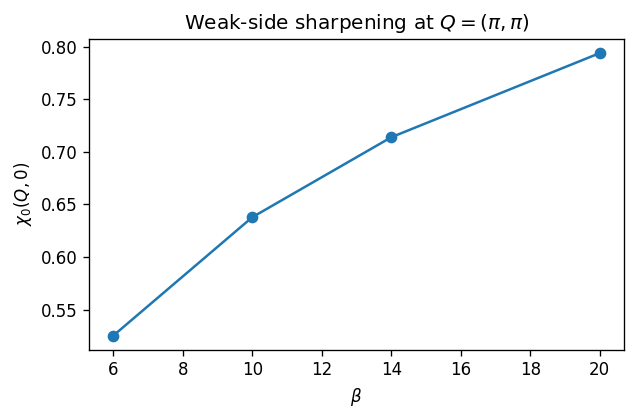

beta=  6.0  χ0(Q)=0.525450  →  U_c≈1.903130
beta= 10.0  χ0(Q)=0.637930  →  U_c≈1.567569
beta= 14.0  χ0(Q)=0.713907  →  U_c≈1.400743
beta= 20.0  χ0(Q)=0.793851  →  U_c≈1.259683


In [15]:
betas = [6.0, 10.0, 14.0, 20.0]
chi0Q_vs_beta = []

for b in betas:
    tmp = RPAConfig(**{**cfg_rpa.__dict__, "beta": b})
    c0  = chi0_static(tmp)
    ixQ, iyQ = find_nearest_q_index(tmp.Nx, tmp.Ny, (np.pi, np.pi))
    chi0Q_vs_beta.append(float(c0[ixQ, iyQ]))

plt.figure(figsize=(5.4,3.6))
plt.plot(betas, chi0Q_vs_beta, marker='o')
plt.xlabel(r'$\beta$'); plt.ylabel(r'$\chi_0(Q,0)$')
plt.title(r'Weak-side sharpening at $Q=(\pi,\pi)$')
plt.tight_layout()
plt.savefig("rpa_beta_sharpening.png", dpi=300, bbox_inches='tight')
plt.show()

for b, val in zip(betas, chi0Q_vs_beta):
    print(f"beta={b:>5.1f}  χ0(Q)={val:.6f}  →  U_c≈{1.0/val:.6f}")


In [16]:
# === DQMC strong-side diagnostics from your table ===
import numpy as np
import pandas as pd

# Your data (Nx, Ny, U, beta, L, D, S(Q)/N_or_SQ)
rows = [
    (8, 8, 4, 6, 120, 0.133685, 0.179386),
    (8, 6, 4, 6, 120, 0.136976, 0.182881),
    (6, 6, 4, 6, 120, 0.137698, 0.184007),
    (6, 4, 4, 6, 120, 0.138420, 0.191427),
    (4, 4, 4, 6, 120, 0.142785, 0.187751),
    (4, 2, 4, 6, 120, 0.143229, 0.209738),
    (2, 2, 4, 6, 120, 0.131103, 0.236669),
]
df = pd.DataFrame(rows, columns=["Nx","Ny","U","beta","L","D","SQ_per_site"])

# Derived quantities
df["m2_local"] = 1.0 - 2.0*df["D"]                    # <m^2> per site
df["mz2"]      = df["m2_local"]/3.0                   # isotropic SU(2) assumption
# Peak-share ratios:
#  - If S is full-spin S(q)=<S·S>: sum_q S(q)/N = <m^2>
#  - If S is a single component S^zz(q): sum_q S^zz(q)/N = <m_z^2>
df["R_fullspin"] = df["SQ_per_site"] / df["m2_local"]
df["R_zz"]       = df["SQ_per_site"] / df["mz2"]

# Pretty print
show_cols = ["Nx","Ny","D","m2_local","SQ_per_site","R_fullspin","R_zz"]
disp = df[show_cols].copy()
print(disp.to_string(index=False, float_format=lambda x: f"{x:.6f}"))

# Summary lines for the text
m2_min, m2_max = df["m2_local"].min(), df["m2_local"].max()
R_full_large = df.loc[df["Nx"]*df["Ny"]>=36, "R_fullspin"].mean()  # 6x6, 6x4, 8x6, 8x8
R_zz_large   = df.loc[df["Nx"]*df["Ny"]>=36, "R_zz"].mean()
print(f"\n[summary] <m^2> ≈ {0.5*(m2_min+m2_max):.3f} (range {m2_min:.3f}–{m2_max:.3f}) "
      f"at U=4, β=6;  peak-share R ≈ {R_full_large:.3f} (full-spin) "
      f"or ≈ {R_zz_large:.3f} (S^zz) on N≥36 lattices.")


ModuleNotFoundError: No module named 'pandas'

### DQMC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from functools import reduce 
from scipy.linalg import qr
from scipy.linalg import expm
from joblib import Parallel, delayed
from numpy.linalg import slogdet
import time

In [ ]:
Nx, Ny = 6, 6
N = Nx * Ny
beta = 1.0
L = 10
dt = beta / L
U = 10.0
mu = 0. # half filling as U*(nu - .5)*(nd * .5)
nwarm = 20
nmeas = 50
lmbd = np.arccosh(np.exp(dt * U * 0.5))

In [ ]:
def build_K(Nx, Ny):
    N = Nx * Ny
    K = np.zeros((N, N))
    def idx(x, y): return x + Nx * y
    for x in range(Nx):
        for y in range(Ny):
            i = idx(x, y)
            j = idx((x + 1) % Nx, y)
            K[i, j] = K[j, i] = 1
            j = idx(x, (y + 1) % Ny)
            K[i, j] = K[j, i] = 1
    return K

K = build_K(Nx, Ny)
K -= mu * np.eye(N)
exp_dtK = expm(-dt * K)

s = np.random.choice([-1, 1], size=(N, L))
lmbd = np.arccosh(np.exp(dt * U * 0.5))

def make_expV(s, lmbd,L):
    expVu = np.array([np.diag(np.exp(lmbd * s[:, l])) for l in range(L)])
    expVd = np.array([np.diag(np.exp(-lmbd * s[:, l])) for l in range(L)])
    return expVu, expVd

In [ ]:
def make_B_set(exp_dtK, expV):
    return np.array([exp_dtK @ expV[l] for l in range(expV.shape[0])])

def calc_green(B_set,N):
    prod = np.eye(N)
    for B in B_set[::-1]:
        prod = B @ prod
    G = np.linalg.inv(np.eye(N) + prod)
    return G, prod

In [ ]:
def dqmc_mc_run(seed, Nx, Ny, beta, L, U, mu, nwarm, nmeas, lmbd, exp_dtK, sign_meas = False):
    np.random.seed(seed)
    N = Nx * Ny

    s = np.random.choice([-1, 1], size=(N, L))
    meas_res = []
    sign_list = []
    for sweep in range(nwarm + nmeas):
        expVu, expVd = make_expV(s, lmbd, L)
        Blu_set = make_B_set(exp_dtK, expVu)
        Bld_set = make_B_set(exp_dtK, expVd)
        gu, prod_u = calc_green(Blu_set, N)
        gd, prod_d = calc_green(Bld_set, N)

        for l in range(L):
            for i in range(N):
                delta = -2 * lmbd * s[i, l]
                e_u = np.exp(delta)
                e_d = np.exp(-delta)
                p_up = 1 + (1 - gu[i, i]) * (e_u - 1)
                p_dn = 1 + (1 - gd[i, i]) * (e_d - 1)
                p_acc = abs(p_up * p_dn)

                if np.random.rand() < p_acc:
                    s[i, l] *= -1  
                    expVu, expVd = make_expV(s, lmbd, L)
                    Blu_set = make_B_set(exp_dtK, expVu)
                    Bld_set = make_B_set(exp_dtK, expVd)
                    gu, prod_u = calc_green(Blu_set, N)
                    gd, prod_d = calc_green(Bld_set, N)

        if sweep >= nwarm:
            nup = np.sum(1 - np.diag(gu)) / N
            ndn = np.sum(1 - np.diag(gd)) / N
            doubleocc = np.sum((1 - np.diag(gu)) * (1 - np.diag(gd))) / N
            meas_res.append((nup, ndn, doubleocc))
            if sign_meas:
                sign_u, logdet_u = slogdet(np.eye(N) + prod_u)
                sign_d, logdet_d = slogdet(np.eye(N) + prod_d)
                # print(sign_u, sign_d, logdet_u, logdet_d)  # Add this line!
                sign_list.append(sign_u * sign_d)
    
    nup_avg = np.mean([r[0] for r in meas_res])
    ndn_avg = np.mean([r[1] for r in meas_res])
    doubleocc_avg = np.mean([r[2] for r in meas_res])
    m2z = nup_avg + ndn_avg - 2 * doubleocc_avg
    
    if sign_meas:
        # print(sign_list[:10])
        return nup_avg, ndn_avg, doubleocc_avg, m2z, np.mean(sign_list)
    else:
        return nup_avg, ndn_avg, doubleocc_avg, m2z

In [ ]:
K = build_K(Nx, Ny)
K -= mu * np.eye(N)
exp_dtK = expm(-dt * K)

n_jobs = 2
seeds = [int(time.time()) + i * 104729 for i in range(n_jobs)]

results = Parallel(n_jobs=n_jobs)(
    delayed(dqmc_mc_run)(seed, Nx, Ny, beta, L, U, mu, nwarm, nmeas, lmbd, exp_dtK) for seed in seeds
)


In [ ]:
results = np.array(results)
nup_avg = results[:,0].mean()
ndn_avg = results[:,1].mean()
doubleocc_avg = results[:,2].mean()
m2z_avg = results[:,3].mean()
# sign_avg = results[:,-1].mean()
print(f"<nup> = {nup_avg:.4f}, <ndn> = {ndn_avg:.4f}, <double_occ> = {doubleocc_avg:.4f}")
print(f"<m2z> = {m2z_avg:.4f} (MPI -np {n_jobs})")
# print(f"<sign> = {sign_avg:.4f}")

<nup> = 0.5123, <ndn> = 0.4877, <double_occ> = 0.0317
<m2z> = 0.9366 (MPI -np 2)
